In [1]:
import hdf5_getters as GETTERS
import h5py
import glob
from pyspark.sql import SparkSession
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

import numpy as np
import hdf5_getters as GETTERS
import h5py
import glob
import pandas as pd
import matplotlib

#### 1. Crear la sesión con SPARK

In [2]:

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('XML ETL') \
    .master("local[*]") \
    .config('job.local.dir', 'file:/models/music-recommender-model') \
    .getOrCreate()

df = spark.range(10).toDF("number")
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/14 15:26:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
+------+



In [19]:
# Stop Spark session
spark.stop()

In [15]:
df_test = spark.range(10)  # 1 millón de filas
print(df_test.count())  # Debe devolver 1,000,000

10


#### 2 - Carga del Dataset y Limpieza

In [3]:
df = spark.read.parquet("/opt/bitnami/spark/datasets/millionsong.parquet")

In [31]:
from pyspark.sql.functions import col, sin, cos, lit, when
import math

# 1. Eliminar columna 'danceability' si está presente
df = df.drop("danceability")

# 2. Filtrar tempo razonable
df = df.filter((col("tempo") >= 40) & (col("tempo") <= 250))

# 3. Filtrar time_signature válidos (1–5)
df = df.filter((col("time_signature") >= 1) & (col("time_signature") <= 5))

# 4. Codificar circularmente 'key'
df = df.withColumn("key_sin", sin(2 * math.pi * col("key") / lit(12)))
df = df.withColumn("key_cos", cos(2 * math.pi * col("key") / lit(12)))

# 5. Transformar 'loudness' a positivo para mejor escalado
min_loudness = df.select("loudness").agg({"loudness": "min"}).collect()[0][0]
df = df.withColumn("loudness_pos", col("loudness") + abs(min_loudness) + 1)

# 6. Crear 'mode_major' binaria por claridad
df = df.withColumn("mode_major", when(col("mode") == 1, 1).otherwise(0))


#### Entrenar el Modelo

In [50]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col, expr
from pyspark.ml.functions import vector_to_array, array_to_vector

# 1. Definir columnas a usar
feature_cols = ['tempo', 'loudness_pos', 'key_sin', 'key_cos', 'mode_major', 'time_signature']

# 2. VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_assembled = assembler.transform(df)

# 3. Escalado estándar
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# 4. Convertir a array y aplicar pesos personalizados
df_scaled = df_scaled.withColumn("scaled_array", vector_to_array("scaled_features"))

# 5. Aplicar pesos manuales (deben coincidir en orden con feature_cols)
weights = [5.0, 1.0, 2.0, 2.0, 0.5, 0.5]  # tempo | loudness | key_sin | key_cos | mode | time_signature

weighted_expr = f"transform(scaled_array, (x, i) -> x * array({','.join(map(str, weights))})[i])"
df_weighted = df_scaled.withColumn("weighted_scaled_features", array_to_vector(expr(weighted_expr)))

# 6. KMeans clustering con k=10
kmeans = KMeans(
    featuresCol='weighted_scaled_features',
    predictionCol='cluster_id',
    k=10,
    seed=42
)
model = kmeans.fit(df_weighted)

# 7. Asignar cluster
df_with_cluster = model.transform(df_weighted)

# 8. Ver resultados
df_with_cluster.select("title", "artist", "cluster_id").show(10, truncate=False)


+--------------------------------+---------------------------------+----------+
|title                           |artist                           |cluster_id|
+--------------------------------+---------------------------------+----------+
|Scream                          |Adelitas Way                     |5         |
|A Poor Recipe For Civic Cohesion|Western Addiction                |4         |
|I Didn't Mean To                |Casual                           |5         |
|The Lark In The Clear Air       |Alquimia                         |5         |
|Soul Deep                       |The Box Tops                     |4         |
|Hit Da Scene                    |Quest_ Pup_ Kevo                 |6         |
|Come On (Album Version)         |Super Deluxe                     |9         |
|Heartache People                |Big Brother & The Holding Company|4         |
|Andalucia                       |Stanley Black                    |5         |
|Amor De Cabaret                 |Sonora

In [6]:
df_scaled.show(1)

+------------------+------+------------+------+---+----+--------------+--------+------------+--------------------+--------------------+--------------------+
|           song_id| title|      artist| tempo|key|mode|time_signature|loudness|danceability|        features_vec|     scaled_features|        scaled_array|
+------------------+------+------------+------+---+----+--------------+--------+------------+--------------------+--------------------+--------------------+
|SOBLFFE12AF72AA5BA|Scream|Adelitas Way|99.944|  1|   1|             4|  -4.769|         0.0|[99.9440002441406...|[2.85098281878643...|[2.85098281878643...|
+------------------+------+------------+------+---+----+--------------+--------+------------+--------------------+--------------------+--------------------+
only showing top 1 row



#### Recomendación 

In [24]:
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeansModel

# Supongamos que tienes ya definido:
# model, scaler_model, assembler, df_scaled

# Simulamos la nueva canción
new_song = {
    'tempo': 120.0,
    'loudness': -5.0,
    'danceability': 1000,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0,
    'song_id': 'NEW_SONG_ID'
}


# Convertimos a Spark DataFrame
new_song_df_pd = pd.DataFrame([new_song])
new_song_df = spark.createDataFrame(new_song_df_pd)

#  Ensamblamos y escalamos usando el pipeline original
new_song_vec = assembler.transform(new_song_df)
new_song_scaled = scaler_model.transform(new_song_vec)

# Hacemos la predicción de cluster
new_song_pred = model.transform(new_song_scaled)
predicted_cluster = new_song_pred.select(
    "cluster_id").collect()[0]["cluster_id"]

print(f"La nueva canción ha sido asignada al cluster: {predicted_cluster}")

# Buscamos canciones del dataset original en el mismo cluster

# Si no habías guardado los clusters en el df original:
df_with_cluster = model.transform(df_scaled)

# Filtramos por el mismo cluster
similar_songs = df_with_cluster.filter(
    df_with_cluster.cluster_id == predicted_cluster)

# Mostramos algunas recomendaciones (por ejemplo 3)
similar_songs.select("song_id").limit(3).show()

La nueva canción ha sido asignada al cluster: 5
+------------------+
|           song_id|
+------------------+
|SOBLFFE12AF72AA5BA|
|SONHOTT12A8C13493C|
|SOFSOCN12A8C143F5D|
+------------------+



In [14]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

                song_id                              title           artist
0    SOZECOE12AB017E615  Diamonds Are A Girl's Best Friend  Gloria De Haven
84   SOPJEXC12A6D4FB529                Hot Dental Supplies      Marga Gomez
149  SOJXYFD12A8C143701         The Ferocious O' Flahertys       Joe Heaney


#### Guardar el modelo

In [15]:
from pyspark.ml import Pipeline

# Creamos el pipeline con los stages que usaste durante el entrenamiento
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Lo ajustamos sobre el dataframe ya escalado
pipeline_model = pipeline.fit(df)

In [16]:
pipeline_model.write().overwrite().save("file:///models/music-recommender-model")

##### Guardar las canciones y a que cluster pertenecen

In [17]:
df_with_cluster.show(5)

+-------+--------+---------+----+----+--------------+------------------+--------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|  tempo|loudness| duration| key|mode|time_signature|           song_id|               title|              artist|     timbre_mean_0|     timbre_std_0|      timbre_mean_1|      timbre_std_1|      timbre_mean_2|      timbre_std_2|      timbre_mean_3|      timbre_std_3|     timbre_mean_4|      timbre_std_4|      timbre_mean_5|      timbre_std_5|      timbre_mean_6|     

In [18]:
df_export = df_with_cluster.select("title", "artist", "cluster_id")
df_export.write.csv("songs_with_cluster", header=True, mode="overwrite")

In [19]:
df_export.toPandas().to_csv("songs_with_cluster.csv", index=False)

#### Cargar el Modelo

In [5]:
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load("file:///models/music-recommender-model")

In [6]:
# Crear nueva canción con timbre simulado
new_song = {
    'tempo': 120.0,
    'loudness': -5.0,
    'danceability': 60,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0,
    'track_name': 'New Song',
    'artist_name': 'Unknown Artist'
}



# Convertir a DataFrame de Spark
df_new = spark.createDataFrame(pd.DataFrame([new_song]))

# Predecir cluster directamente con el pipeline
predicted = loaded_model.transform(df_new)
predicted_cluster = predicted.select("cluster_id").collect()[0]["cluster_id"]

print(f"La canción fue asignada al cluster {predicted_cluster}")

df_with_clusters = loaded_model.transform(df_scaled)

recommendations = df_with_clusters.filter(
    df_with_clusters.cluster_id == predicted_cluster
).select("track_name", "artist_name").limit(3)

recommendations.show()


IllegalArgumentException: duration does not exist. Available: tempo, loudness, danceability, key, mode, time_signature, track_name, artist_name

In [15]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

               song_id           title              artist
19  SOQBCSM12AC4687CDE  Pete's Crusade  Light Of The World


### Mejorar el modelo (Métricas)

In [13]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol='scaled_features',
    predictionCol='cluster_id',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

silhouette = evaluator.evaluate(df_with_cluster)
print(f"Silhouette score (k=20): {silhouette}")

Silhouette score (k=20): 0.09626977613159433


In [36]:
ks = list(range(2, 31))  # Por ejemplo, de 2 a 30 clusters

for k in ks:
    kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster_id', k=k, seed=42)
    model = kmeans.fit(df_scaled)
    df_clusters = model.transform(df_scaled)

    silhouette = evaluator.evaluate(df_clusters)
    print(f"k={k}, silhouette_score={silhouette:.4f}")

k=2, silhouette_score=0.2371


k=3, silhouette_score=0.3178


k=4, silhouette_score=0.2700


k=5, silhouette_score=0.3000


k=6, silhouette_score=0.2849


k=7, silhouette_score=0.3360


k=8, silhouette_score=0.3205


k=9, silhouette_score=0.3543


k=10, silhouette_score=0.3766


ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

#### Que faeatures son más significativas

In [19]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(df_scaled)
explained = model.explainedVariance.toArray()

for i, var in enumerate(explained):
    print(f"PC{i+1}: {var:.4f}")



PC1: 0.2550
PC2: 0.2321
PC3: 0.1950
PC4: 0.1605
PC5: 0.1574


In [10]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.8 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


### Visualizar clusters

In [59]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Paso 1: Asegurarse de tener el DF con los clusters
# (df_with_cluster ya lo tienes con la columna 'cluster_id')

# Paso 2: Aplicar PCA para reducir a 2 dimensiones
pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Paso 3: Convertir a Pandas para graficar
df_plot = df_pca.select("pca_features", "cluster_id").toPandas()

# Extraer coordenadas PCA
pca_values = df_plot["pca_features"].apply(lambda x: x.toArray())
pca_2d = np.stack(pca_values.values)
x, y = pca_2d[:, 0], pca_2d[:, 1]



# Paso 4: Graficar con colores por cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=df_plot["cluster_id"], cmap="tab10", s=10, alpha=0.6)
plt.title("Visualización de Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


AttributeError: 'list' object has no attribute '_jdf'

In [ ]:
!pip install scikit-learn

In [51]:
# Suponiendo que ya tienes entrenado tu modelo como 'model'
centroids = model.clusterCenters()

# Imprimir los centroides
for i, center in enumerate(centroids):
    print(f"Centroide {i}: {center}")


Centroide 0: [18.77142445  9.626343    1.29529528  2.15928658  0.84818619  1.6272286 ]
Centroide 1: [13.2151002   9.35924884 -2.28778064 -0.8045236   0.72695963  1.56140883]
Centroide 2: [29.91863447  9.71738025 -0.19167176  0.16872582  0.71166996  1.54662639]
Centroide 3: [23.82781966  9.72828975 -1.29241231  1.46614261  0.67735666  1.59694877]
Centroide 4: [18.8099166   9.65993802 -1.32477291 -2.26670592  0.78672031  1.63642092]
Centroide 5: [13.27125613  9.38827122  0.7657632   2.2140454   0.76364963  1.57065521]
Centroide 6: [23.94743469  9.69496064  1.16353816 -1.26066599  0.72219871  1.58521133]
Centroide 7: [18.4604932   9.54263063  2.21037642 -1.51626939  0.6189673   1.60427592]
Centroide 8: [18.57989567  9.67777519 -2.34673879  1.14221059  0.50466307  1.64142895]
Centroide 9: [13.12880811  9.29740357  1.66099539 -1.8279292   0.63254975  1.56212631]


In [54]:
cluster_distribution = df_with_cluster.groupBy("cluster_id").count().orderBy("cluster_id")
cluster_distribution.show()

+----------+------+
|cluster_id| count|
+----------+------+
|         0|130489|
|         1|114503|
|         2| 55049|
|         3| 89826|
|         4|101482|
|         5|130420|
|         6| 83698|
|         7| 70963|
|         8|110738|
|         9| 81811|
+----------+------+



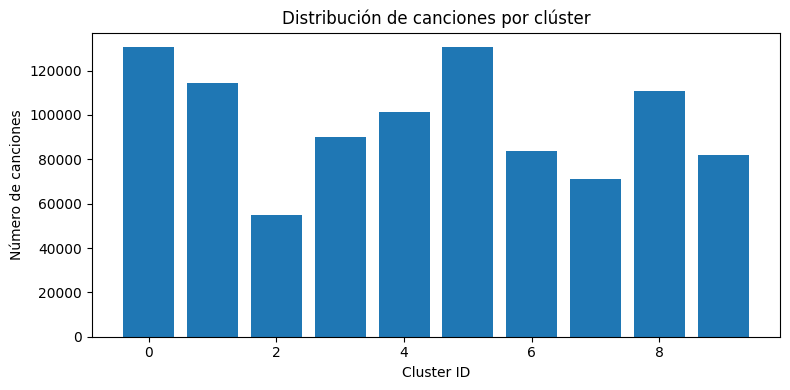

In [57]:
pdf = cluster_distribution.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(pdf['cluster_id'], pdf['count'])
plt.xlabel("Cluster ID")
plt.ylabel("Número de canciones")
plt.title("Distribución de canciones por clúster")
plt.tight_layout()
plt.show()

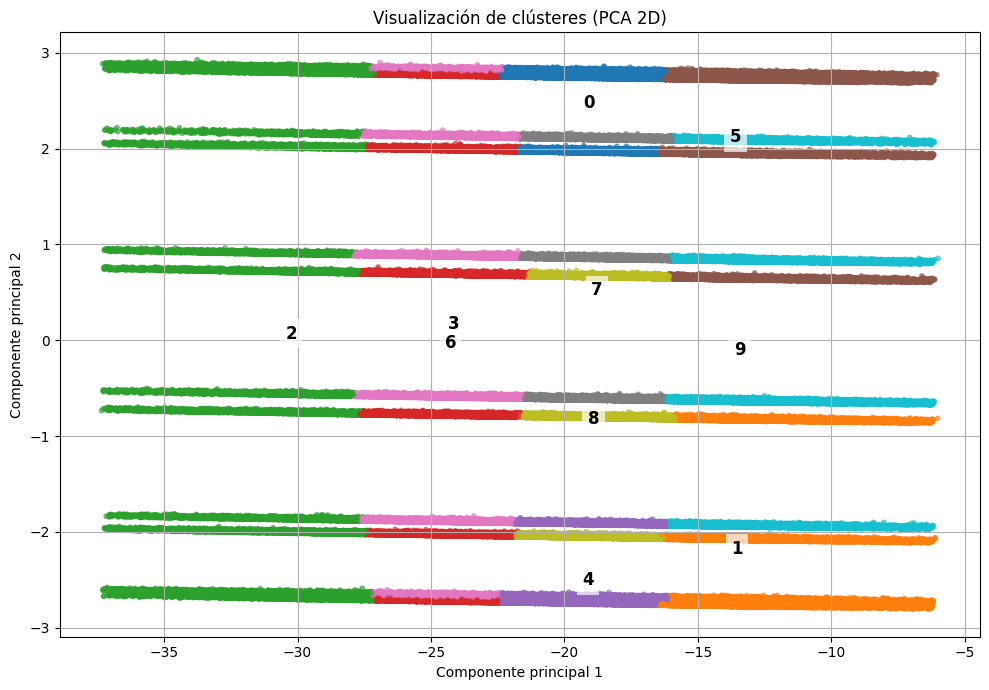

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Obtener el PCA como ya haces
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Paso 2: Convertir a Pandas
df_plot = df_pca.select("pca_features", "cluster_id").toPandas()

# Paso 3: Extraer coordenadas PCA
pca_values = df_plot["pca_features"].apply(lambda x: x.toArray())
pca_2d = np.stack(pca_values.values)
x, y = pca_2d[:, 0], pca_2d[:, 1]
cluster_ids = df_plot["cluster_id"].values

# Paso 4: Calcular centroide visual por clúster
import pandas as pd
df_plot_xy = pd.DataFrame({'x': x, 'y': y, 'cluster_id': cluster_ids})

centroids_visuales = df_plot_xy.groupby('cluster_id')[['x', 'y']].mean().reset_index()

# Paso 5: Plotear
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=cluster_ids, cmap='tab10', s=10, alpha=0.6)

# Añadir etiquetas en los centroides visuales
for _, row in centroids_visuales.iterrows():
    plt.text(row['x'], row['y'], str(int(row['cluster_id'])), fontsize=12, fontweight='bold', 
             ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title("Visualización de clústeres (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Convertir a Pandas
df_vis = df_pca.select("pca_features", "cluster_id").withColumn("x", col("pca_features")[0]).withColumn("y", col("pca_features")[1])
pdf_vis = df_vis.select("x", "y", "cluster_id").toPandas()

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pdf_vis, x="x", y="y", hue="cluster_id", palette="tab10")
plt.title("Visualización PCA de los clústeres")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Clúster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


AnalysisException: [INVALID_EXTRACT_BASE_FIELD_TYPE] Can't extract a value from "pca_features". Need a complex type [STRUCT, ARRAY, MAP] but got "STRUCT<type: TINYINT, size: INT, indices: ARRAY<INT>, values: ARRAY<DOUBLE>>".

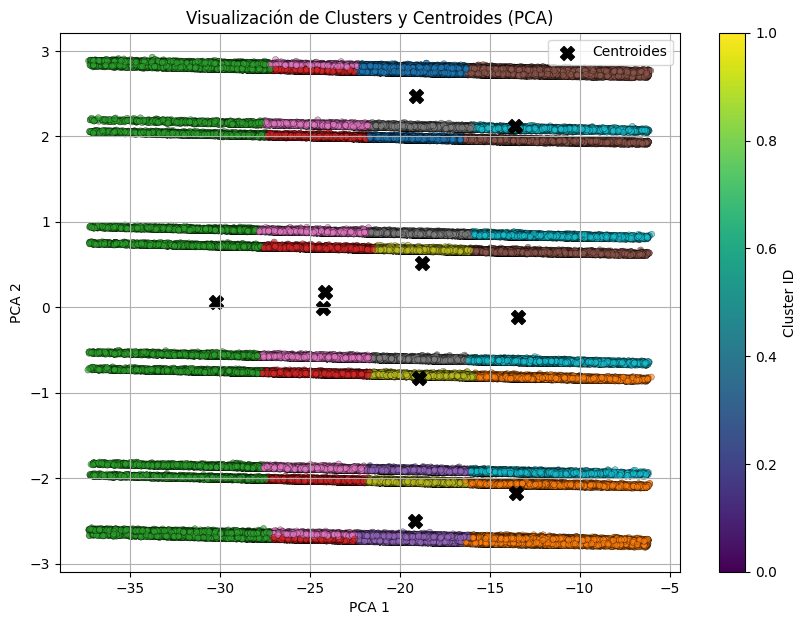

In [53]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
import matplotlib.pyplot as plt
import numpy as np

# 1. Aplicar PCA a los datos
pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# 2. Convertir a Pandas para graficar
df_plot = df_pca.select("pca_features", "cluster_id").toPandas()
pca_points = np.stack(df_plot["pca_features"].apply(lambda x: x.toArray()).values)

# 3. Proyectar los centroides con el mismo PCA
centroids = model.clusterCenters()
centroid_rows = [Row(weighted_scaled_features=Vectors.dense(c)) for c in centroids]
centroid_df = spark.createDataFrame(centroid_rows)
centroid_pca = pca_model.transform(centroid_df)
centroid_pd = centroid_pca.select("pca_features").toPandas()
centroid_coords = np.stack(centroid_pd["pca_features"].apply(lambda x: x.toArray()).values)

# 4. Graficar
plt.figure(figsize=(10, 7))
plt.scatter(pca_points[:, 0], pca_points[:, 1],
            c=df_plot["cluster_id"], cmap="tab10", s=20, alpha=0.6, edgecolor='k', linewidth=0.3)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1],
            c='black', s=100, marker='X', label='Centroides')

plt.title("Visualización de Clusters y Centroides (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
import sklearn
print(sklearn.__version__)

1.7.0


In [ ]:
import pandas as pd
import sweetviz as sv

df = pd.read_parquet("/opt/bitnami/spark/datasets/millionsong.parquet")
# Crear análisis
report = sv.analyze([df, "Canciones"])
# Mostrar en el navegador o notebook
report.show_html("reporte_sweetviz.html")

In [40]:
df_with_cluster.groupBy("cluster_id").avg("tempo", "loudness", "key", "mode", "time_signature").orderBy("cluster_id").show()

+----------+------------------+-------------------+------------------+------------------+-------------------+
|cluster_id|        avg(tempo)|      avg(loudness)|          avg(key)|         avg(mode)|avg(time_signature)|
+----------+------------------+-------------------+------------------+------------------+-------------------+
|         0|126.86015611554762|  -9.69655746408345| 0.977201143391397|0.7995769758370438| 3.5813900022224097|
|         1| 89.26507724084897|-11.065680349986147| 8.321738295066504|0.6850388199435823| 3.4364339798957233|
|         2|202.19049052114232|  -9.23158633222715| 5.370706098203419|0.6707478791622009|  3.404239859034678|
|         3|161.01473373084556| -9.175417529181138| 6.200565537817559|0.6386124284728253| 3.5146616792465433|
|         4| 126.9666473326423| -9.526212007850098|  6.95516446266333|0.7412546067282868| 3.6011213811316294|
|         5|  89.6848390893654|-10.914818807892582|2.7530900168685783|0.7198972550222359| 3.4570004600521393|
|         

#### Intento con bins

In [17]:
from pyspark.sql.functions import floor, col, concat_ws

# Crear bins de tempo (ej: de 5 en 5)
df_binned = df.withColumn("tempo_bin", floor(col("tempo") / 5) * 5)

# Agrupar por bin de tempo y key
df_binned_grouped = df_binned.groupBy("tempo_bin", "key").count().orderBy("tempo_bin", "key")


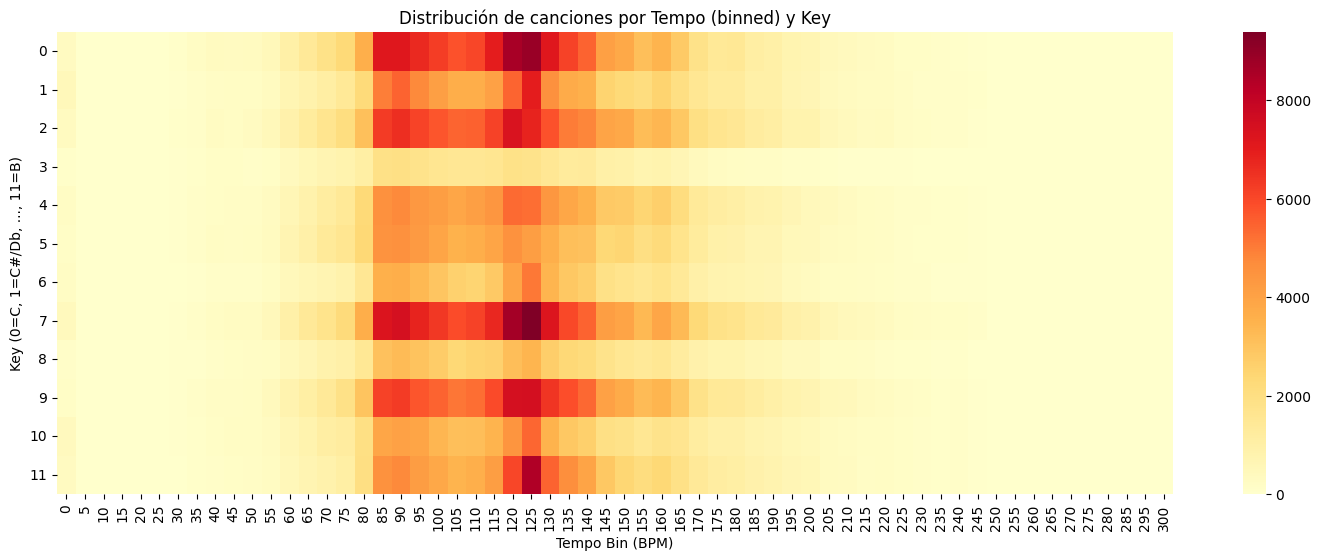

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convertir a matriz de calor
heatmap_data = df_pandas.pivot(index="key", columns="tempo_bin", values="count").fillna(0)

plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=False)

plt.title("Distribución de canciones por Tempo (binned) y Key")
plt.xlabel("Tempo Bin (BPM)")
plt.ylabel("Key (0=C, 1=C#/Db, ..., 11=B)")
plt.yticks(rotation=0)
plt.show()


In [20]:
df_pandas = df_binned_grouped.toPandas()

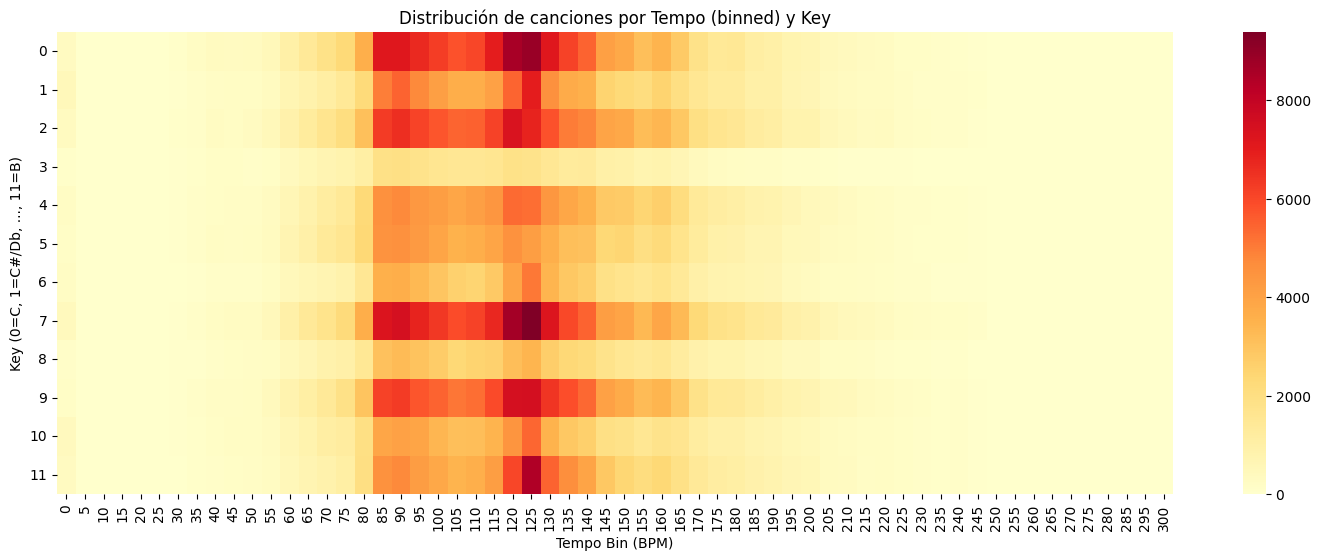

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convertir a matriz de calor
heatmap_data = df_pandas.pivot(index="key", columns="tempo_bin", values="count").fillna(0)

plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=False)

plt.title("Distribución de canciones por Tempo (binned) y Key")
plt.xlabel("Tempo Bin (BPM)")
plt.ylabel("Key (0=C, 1=C#/Db, ..., 11=B)")
plt.yticks(rotation=0)
plt.show()
